In [1]:
from dysh.spectra.spectrum import Spectrum
import numpy as np
from scipy.stats import norm
import astropy.units as u
import matplotlib.pyplot as plt
from dysh.fits.sdfitsload import SDFITSLoad
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.spectra.scan import PSScan, GBTPSScan
import pandas
from copy import deepcopy
pandas.set_option('display.max_rows', 100)
from astropy.modeling.fitting import LevMarLSQFitter,LinearLSQFitter
from specutils import Spectrum1D, SpectrumList,SpectralRegion
from astropy.nddata import StdDevUncertainty
from specutils.fitting import fit_continuum
import matplotlib.pyplot as plt
from dysh.spectra import dcmeantsys,tsys_weight,average
from dysh.plot.specplot import SpectrumPlot
from astropy.io import fits
from astropy.table import Table
import pandas as pd
#%matplotlib notebook

-------------

# 1. GBTFITSLoad and position-switch calibration testing
change to use your specific `datadir`

In [2]:
datadir = '/data/gbt'
#f = datadir + '/examples/misc/ngc5291.fits'
f = datadir + '/examples/onoff-L/data/TGBT21A_501_11.raw.vegas.fits'
#f = datadir + 'examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.A.fits'
#f = datadir + '/examples/mixed-fs-ps/data/AGBT16B_225_05/AGBT16B_225_05.raw.vegas/AGBT16B_225_05.raw.vegas.A.fits'
p = GBTFITSLoad(f)
p.info()

Filename: /data/gbt/examples/onoff-L/data/TGBT21A_501_11.raw.vegas.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   ()      
  1  SINGLE DISH    1 BinTableHDU    245   6040R x 74C   ['32A', '1D', '22A', '1D', '1D', '1D', '32768E', '16A', '6A', '8A', '1D', '1D', '1D', '4A', '1D', '4A', '1D', '1I', '32A', '32A', '1J', '32A', '16A', '1E', '8A', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '8A', '1D', '1D', '12A', '1I', '1I', '1D', '1D', '1I', '1A', '1I', '1I', '16A', '16A', '1J', '1J', '22A', '1D', '1D', '1I', '1A', '1D', '1E', '1D', '1D', '1D', '1D', '1D', '1A', '1A', '8A', '1E', '1E', '16A', '1I', '1I', '1I']   


In [3]:
p.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,152.0,NGC2415,3784.0,OnOff,1.0,1.617185,1.420406,5,2,151,1,286.218008,41.62843
1,153.0,NGC2415,3784.0,OnOff,2.0,1.617185,1.420406,5,2,151,1,286.886521,41.118134


In [4]:
p.summary(verbose=True)

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,IFNUM,FEED,AZIMUTH,ELEVATIO,FDNUM,PLNUM,SIG,CAL
0,152,NGC2415,3784.0,OnOff,1,1.420406,1.420406,0,1,285.951496,42.100624,0,1,T,F
1,152,NGC2415,3784.0,OnOff,1,1.420406,1.420406,0,1,285.951496,42.100624,0,1,T,T
2,152,NGC2415,3784.0,OnOff,1,1.420406,1.420406,0,1,285.951496,42.100624,0,0,T,F
3,152,NGC2415,3784.0,OnOff,1,1.420406,1.420406,0,1,285.951496,42.100624,0,0,T,T
4,152,NGC2415,3784.0,OnOff,1,1.612231,1.420406,1,1,285.951496,42.100624,0,1,T,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,153,NGC2415,3784.0,OnOff,2,1.667359,1.420406,3,1,287.149353,40.652970,0,0,T,T
6036,153,NGC2415,3784.0,OnOff,2,1.720530,1.420406,4,1,287.149353,40.652970,0,1,T,F
6037,153,NGC2415,3784.0,OnOff,2,1.720530,1.420406,4,1,287.149353,40.652970,0,1,T,T
6038,153,NGC2415,3784.0,OnOff,2,1.720530,1.420406,4,1,287.149353,40.652970,0,0,T,F


-----------------------------
# Get total power scan integrations and plot the time average 

In [40]:
tps = p.gettp(scan=152,sig=True,cal=None,bintable=0,ifnum=0,plnum=1)

S  3020
I  604
P  302
F  302
TPROWS len= 302
CALROWS on len= 151
TPSCAN nrows = 302
CALIBRATING
# scanrows 302, # calrows ON 151  # calrows OFF 151


In [62]:
df=p.index(0)[p.index(0)["SCAN"].isin([152])]
set(df["EXPOSURE"]),set(df["FREQRES"]),np.sum(df["EXPOSURE"])
#p._hdu[1].header
set(df["DURATION"])

{0.9982445}

S  3020
C  1510
I  302
P  151
F  151
TPROWS len= 151
CALROWS on len= 151
TPSCAN nrows = 151
CALIBRATING
# scanrows 151, # calrows ON 151  # calrows OFF 151
S  3020
C  1510
I  302
P  151
F  151
TPROWS len= 151
CALROWS on len= 151
TPSCAN nrows = 151
CALIBRATING
# scanrows 151, # calrows ON 151  # calrows OFF 151


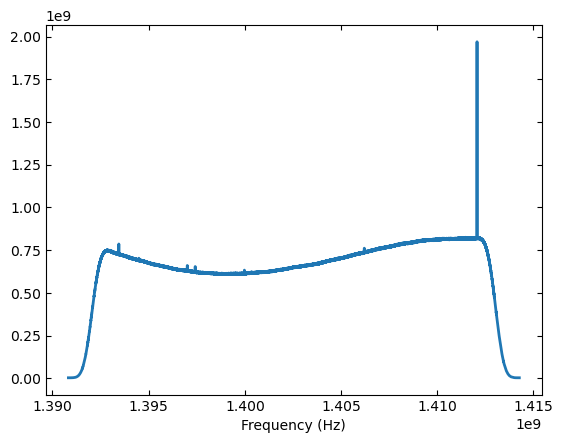

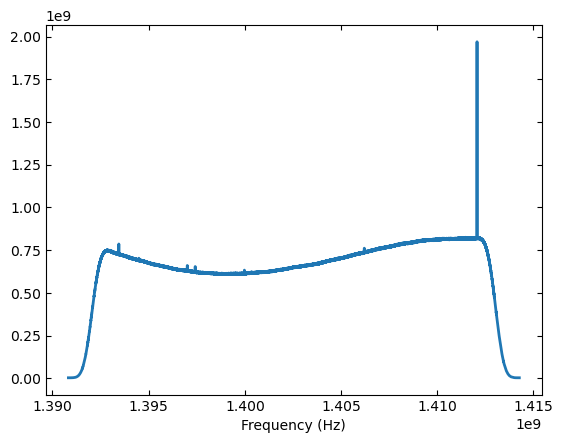

TSYS(cal=T)= 17.08520772676934
TSYS(cal=F)= 17.08520772676934


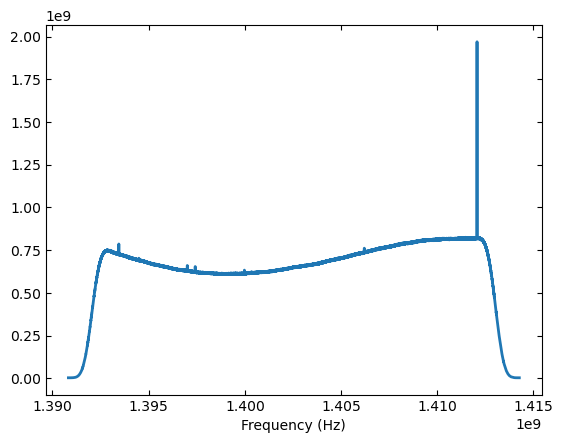

S  3020
C  1510
I  302
P  151
F  151
TPROWS len= 151
CALROWS on len= 151
TPSCAN nrows = 151
CALIBRATING
# scanrows 151, # calrows ON 151  # calrows OFF 151


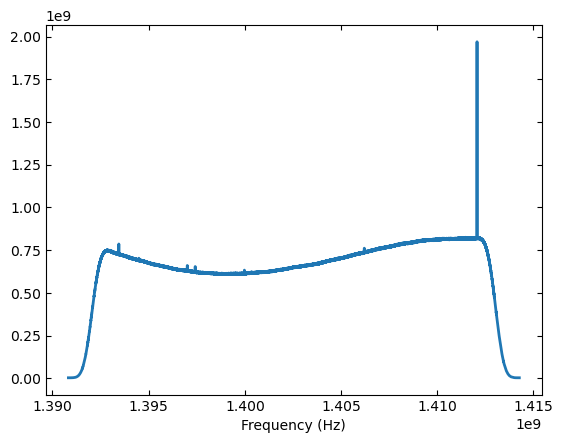

17.08520772676934


In [43]:
tps = p.gettp(scan=152,sig=True,cal=True,bintable=0,ifnum=0,plnum=1)
tps2 = p.gettp(scan=152,sig=True,cal=False,bintable=0,ifnum=0,plnum=1)
s=tps.timeaverage()
s.plot()
so = tps2.timeaverage()
so.plot()
print("TSYS(cal=T)=",s.meta['TSYS'])
print("TSYS(cal=F)=",so.meta['TSYS'])
s2 = (s+so)*0.5
s2.plot()
#(s-so).plot()
tpsc = p.gettp(scan=152,sig=True,cal=True,bintable=0,ifnum=0,plnum=1,calibrate=True)
s4=tpsc.timeaverage()
s4.plot()
s4.data-s.data
print(so.meta["TSYS"])

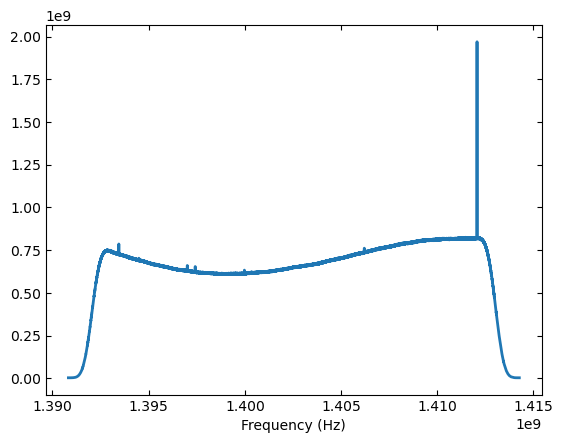

In [7]:
tps.timeaverage(weights='tsys').plot()

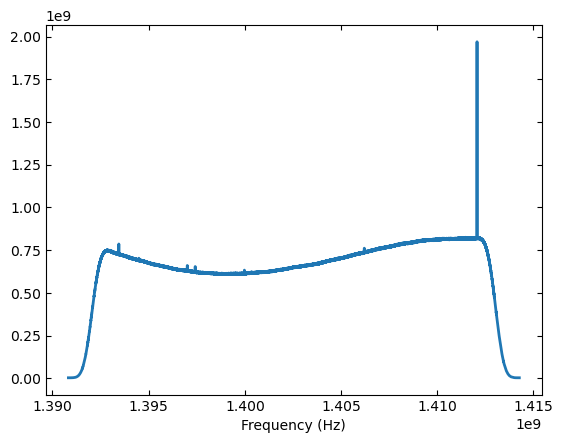

32768 32768


715.2921559810638

In [8]:
freq,counts=np.loadtxt("../testdata/tp152_if0_pl1_fd0.txt",skiprows=3,unpack=True)
freq=freq*1E9
#fig,ax=plt.subplots()
#ax.plot(freq,counts)
ss = s/2.0
s4.plot()
print(len(counts),len(freq))
freq+=np.mean(s.spectral_axis.value-freq)
s4._plotter.axis.plot(freq,counts,color='r')
freq[0]-freq[1]

## get another TP scan with different IF and Polarization and plot the 13th integration

S  3020
C  1510
I  302
P  151
F  151
TPROWS len= 151
CALROWS on len= 151
TPSCAN nrows = 151
CALIBRATING
# scanrows 151, # calrows ON 151  # calrows OFF 151


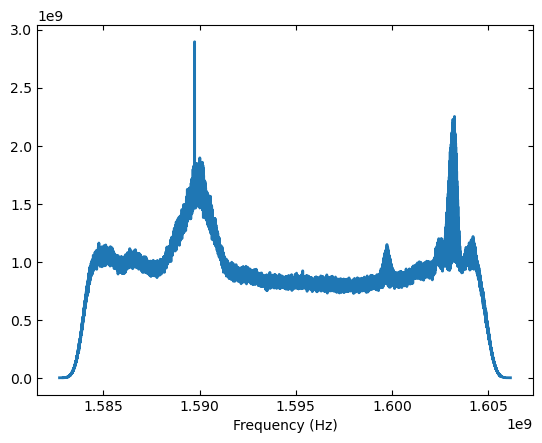

In [9]:
tps = p.gettp(scan=153,sig=True,cal=True,bintable=0,ifnum=1,plnum=1)
tps.total_power(12).plot()

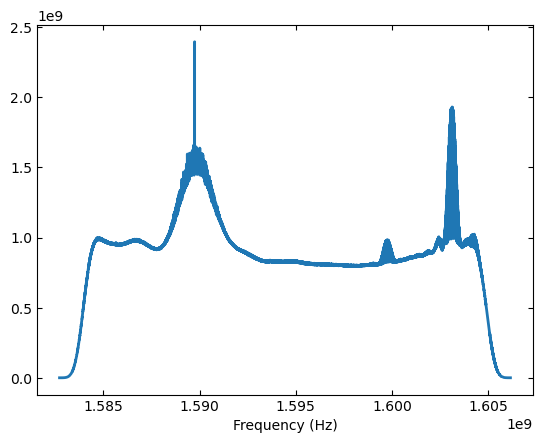

In [10]:
tps.timeaverage().plot()

## Try writing scans or records to FITS files and reading them back in


In [11]:
scanlist = [152]

In [12]:
p.write_scans("/tmp/scans.fits",overwrite=True,checksum=True,output_verify='fix',scans=scanlist)

In [13]:
x1 = fits.open("/tmp/scans.fits")
x1.info()

Filename: /tmp/scans.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   ()      
  1  SINGLE DISH    1 BinTableHDU    210   3020R x 74C   [32A, 1D, 22A, 1D, 1D, 1D, 32768E, 16A, 6A, 8A, 1D, 1D, 1D, 4A, 1D, 4A, 1D, 1I, 32A, 32A, 1J, 32A, 16A, 1E, 8A, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 8A, 1D, 1D, 12A, 1I, 1I, 1D, 1D, 1I, 1A, 1I, 1I, 16A, 16A, 1J, 1J, 22A, 1D, 1D, 1I, 1A, 1D, 1E, 1D, 1D, 1D, 1D, 1D, 1A, 1A, 8A, 1E, 1E, 16A, 1I, 1I, 1I]   


In [14]:
x1[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =               131698 / length of dimension 1                          
NAXIS2  =                 3020 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   74 / number of table fields                         
COMMENT Start of SDFITS CORE keywords/columns.                                  
TELESCOP= 'NRAO_GBT'           / the telescope used                             
COMMENT End of SDFITS CORE keywords/columns.                                    
COMMENT Start of SDFITS DATA column and descriptive axes.                       
CTYPE4  = 'STOKES  '        

In [15]:
x1 = GBTFITSLoad("/tmp/scans.fits")
#x1._ptable[0]
x1._hdu.info()

Filename: /tmp/scans.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   ()      
  1  SINGLE DISH    1 BinTableHDU    210   3020R x 74C   ['32A', '1D', '22A', '1D', '1D', '1D', '32768E', '16A', '6A', '8A', '1D', '1D', '1D', '4A', '1D', '4A', '1D', '1I', '32A', '32A', '1J', '32A', '16A', '1E', '8A', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '8A', '1D', '1D', '12A', '1I', '1I', '1D', '1D', '1I', '1A', '1I', '1I', '16A', '16A', '1J', '1J', '22A', '1D', '1D', '1I', '1A', '1D', '1E', '1D', '1D', '1D', '1D', '1D', '1A', '1A', '8A', '1E', '1E', '16A', '1I', '1I', '1I']   


In [16]:
x1._hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =               131698 / length of dimension 1                          
NAXIS2  =                 3020 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   74 / number of table fields                         
COMMENT Start of SDFITS CORE keywords/columns.                                  
TELESCOP= 'NRAO_GBT'           / the telescope used                             
COMMENT End of SDFITS CORE keywords/columns.                                    
COMMENT Start of SDFITS DATA column and descriptive axes.                       
CTYPE4  = 'STOKES  '        

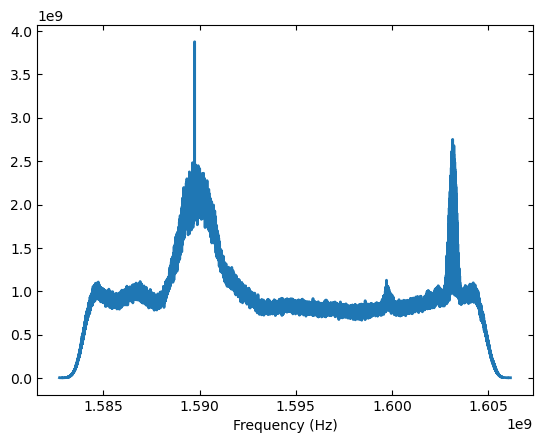

In [19]:
spec4 = p.getspec(4)
sp = SpectrumPlot(spec4)
sp.plot()

## Get a position switch scan and calibrate it.
The default ifnum=0, plnum=0

In [57]:
# eventually this will have calibrate=True as the default, so you don't need to call calibrate().
psscan = p.getps(152)

PSSCAN nrows = 302


In [58]:
psscan.calibrate()

NSPECT 151 len(TCAL) 151


In [60]:
xx=psscan.timeaverage()
type(psscan._calibrated)

numpy.ndarray

### the raw calibrated numpy array

In [22]:
psscan._calibrated

array([array([ 0.09754238, -0.4535061 ,  0.06858956, ...,  0.4810351 ,
              -0.21121033, -0.23867548], dtype=float32)               ,
       array([ 0.7733498 ,  0.01492646, -0.1531026 , ..., -1.3959792 ,
               0.5523352 , -0.42039734], dtype=float32)               ,
       array([ 0.31790158,  0.8603197 , -0.5845505 , ...,  1.6115109 ,
              -0.4261487 ,  0.06145494], dtype=float32)               ,
       array([-0.56308544, -0.8652893 , -1.5464636 , ...,  0.5436567 ,
              -0.2802881 ,  1.1823931 ], dtype=float32)               ,
       array([-0.11248457,  0.984667  ,  0.12548198, ..., -0.09026506,
              -0.8449849 ,  0.74461794], dtype=float32)               ,
       array([-0.08674802, -0.5158194 , -0.20953025, ..., -0.22245705,
               0.27636093, -0.80942893], dtype=float32)               ,
       array([ 0.3130743 , -0.27702832, -0.80119115, ..., -0.69278264,
               0.5380946 ,  0.30442315], dtype=float32)               ,

### A single integration of the calibrated Spectrum

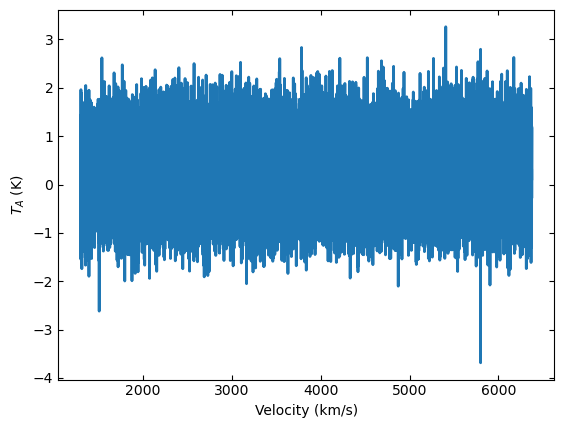

In [23]:
spec1 = psscan.calibrated(3)
sp = SpectrumPlot(spec1)
sp.plot(xaxis_unit="km/s")

### The average spectrum.  
You can plot with equal weights or $T_{sys}$ weighting (the default)
Compare this with GBTIDL `getps, 152`

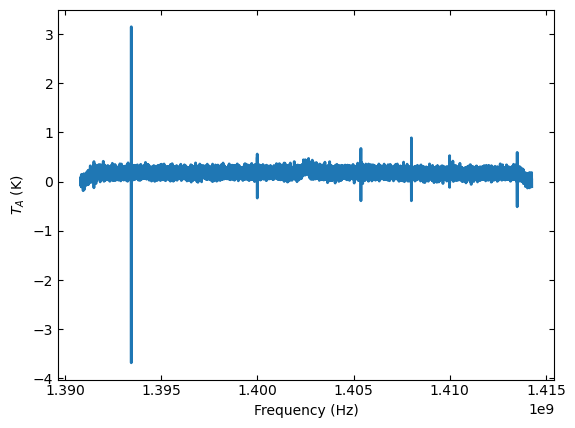

T_sys = 17.16746062950806


In [25]:
t=psscan.timeaverage(weights=None)
t.plot()
print(f"T_sys = {np.mean(psscan.tsys)}")

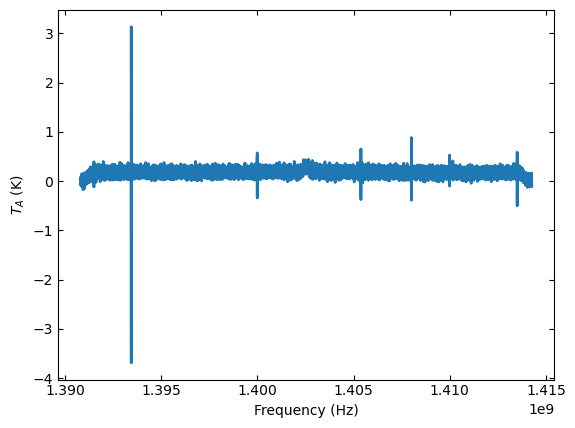

In [26]:
t=psscan.timeaverage(weights='tsys').plot()

### Try a different polarization and IF and use the OFF scan number
GBTIDL `getps, 153, ifnum=1, plnum=1`

In [27]:
psscan = p.getps(152,plnum=1,ifnum=1)
psscan.calibrate()

PSSCAN nrows = 302
NSPECT 151 len(TCAL) 151


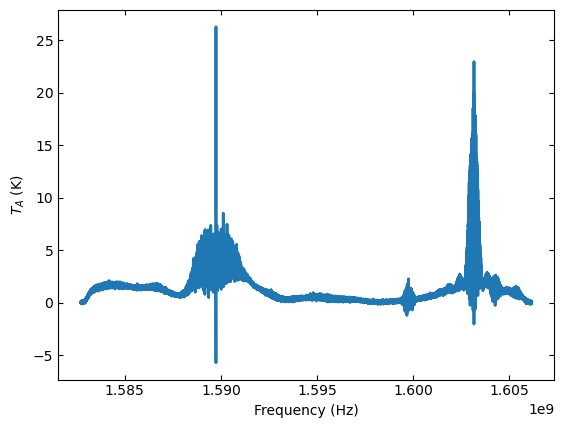

T_sys = 21.243788440351505


In [28]:
psscan.timeaverage().plot()
print(f"T_sys = {np.mean(psscan.tsys)}")

### mixed FS and PS


In [ ]:
datadir = '/data/gbt'
f = datadir + '/examples/mixed-fs-ps/data/AGBT16B_225_05/AGBT16B_225_05.raw.vegas/AGBT16B_225_05.raw.vegas.A.fits'
p = GBTFITSLoad(f)
p.info()
p.summary()

--------------------------------

# SubbeamNOD KPFA Data 

In [29]:
datadir = "/data/gbt/"
f = datadir + 'examples/subbeamnod-Ka/data/TRCO_230413_Ka.raw.vegas/TRCO_230413_Ka.raw.vegas.A.fits'
pnod = GBTFITSLoad(f)
pnod.info()
pnod._hdu[0].header

Filename: /data/gbt/examples/subbeamnod-Ka/data/TRCO_230413_Ka.raw.vegas/TRCO_230413_Ka.raw.vegas.A.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   ()      
  1  SINGLE DISH    1 BinTableHDU    245   5280R x 74C   ['32A', '1D', '22A', '1D', '1D', '1D', '1024E', '16A', '6A', '8A', '1D', '1D', '1D', '4A', '1D', '4A', '1D', '1I', '32A', '32A', '1J', '32A', '16A', '1E', '8A', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '8A', '1D', '1D', '12A', '1I', '1I', '1D', '1D', '1I', '1A', '1I', '1I', '16A', '16A', '1J', '1J', '22A', '1D', '1D', '1I', '1A', '1D', '1E', '1D', '1D', '1D', '1D', '1D', '1A', '1A', '8A', '1E', '1E', '16A', '1I', '1I', '1I']   


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2023-04-13T03:58:07' / date and time this HDU was created            
ORIGIN  = 'NRAO Green Bank'    / origin of observation                          
TELESCOP= 'NRAO_GBT'           / the telescope used                             
INSTRUME= 'VEGAS   '           / backend                                        
SDFITVER= 'sdfits ver1.22'     / this file was created by sdfits                
FITSVER = '1.9     '           / FITS definition version                        

In [30]:
vegas=np.array([0,32,64,96,128,160,192,224,256,288,320,352,384,416,448,480,544,576,608,640,672,
                704,736,768,800,832,864,896,928,960,992|0,32,64,96,128,160,192,224,256,288,320,
                352,384,416,448,480,544,576,608,640,672,704,736,768,800,832,864,896,928,960,992])

In [31]:
tsysidl=np.array([84.9435,82.1865,88.1306,79.4702,83.3359,82.1568,
84.8032,87.5031,82.3827,86.6867,81.2290,83.3456,
154.525,76.3337,121.232,107.034,122.812,122.386,
109.684,126.385,106.435,116.182,120.199,117.069,
55.5695,70.8444,84.2473,84.2600,84.1720,85.6708,
83.8575,84.9475,85.0601,83.6906,82.5538,82.3467,
111.679,114.020,115.357,118.397,105.984,115.007,
113.603,113.097,116.426,115.867,114.906,118.247,
65.3346,72.2251,84.1646,83.3890,84.2675,83.7073,
83.2034,84.5122,84.7987,81.9806,83.8689,82.9380,
103.363,111.527,113.147,101.503,108.444,116.663,
111.407,113.278,115.310,115.436,114.451,117.825,
73.3529,71.0150,83.4908,84.2935,82.8866,83.5213,
85.0363,82.4940,82.6460,83.3778,82.8975,82.3562,
90.8207,139.061,101.555,105.921,110.831,112.511,
111.064,117.958,116.047,114.238,121.151,113.204,
74.1397,72.0670,84.6076,84.3983,83.6667,84.0574,
82.1753,81.9777,82.7533,83.2628,83.1251,84.4301,
72.5894,138.020,105.265,103.819,112.595,115.162,
116.772,115.474,114.101,114.157,115.170,112.846,
])
                                                                                                                  
      

In [32]:
ifnum=0
plnum=0
fdnum=1
scan=43
bintable=0
weights='tsys'
cal=True

In [33]:
df = pnod.index(0)
df = df[df["SCAN"].isin([43])]
print("S",len(df))
df=df[df["SIG"]=='T']
print("SS",len(df))

df =  df[(df['IFNUM'] == ifnum)]
print("I",len(df))
df =  df[(df['PLNUM'] == plnum)]
print("P",len(df))
#df = df[(df['FDNUM'] == fdnum) & (df['IFNUM'] == ifnum) & (df['PLNUM'] == plnum)]
df = df[(df['FDNUM'] == fdnum)]
print("F",len(df))

df=df[df["CAL"]=='F']
print("C",len(df))




S 480
SS 480
I 480
P 240
F 240
C 120


In [34]:

tp1=pnod.gettp(scan,sig=True,cal=cal,bintable=bintable,fdnum=fdnum,plnum=plnum,ifnum=ifnum)
np.mean(np.abs(tp1.tsys))
#np.mean(tp1.tsys,where=((tp1.tsys>0) and (tp1.tsys<100)))
#w=np.where((tp1.tsys>0) &(tp1.tsys<100))[0]
#np.mean(tp1.tsys)
#np.shape(tp1.data)

S  480
C  240
I  240
P  120
F  120
TPROWS len= 120
CALROWS on len= 120
TPSCAN nrows = 120
CALIBRATING
# scanrows 120, # calrows ON 120  # calrows OFF 120


97.5934680213617

In [ ]:
np.average(tp1.tsys,axis=0,weights=tp1._tsys_weight)
np.sqrt(np.sqrt(np.sum(tp1.tsys*tp1.tsys)))
from statistics import geometric_mean,harmonic_mean
geometric_mean(tp1.tsys),harmonic_mean(tp1.tsys)
np.sqrt(np.sum(tp1.tsys*tp1.tsys/tp1._tsys_weight))
np.sum(tsysidl*tsysidl/tp1._tsys_weight)

In [ ]:
np.nanmean(tsysidl),np.nanmean(tp1.tsys),np.nanmean(tsysidl-tp1.tsys)

In [ ]:
tpa=tp1.timeaverage()
tpa.plot()
tpa.meta['TSYS']

In [ ]:
subref=-1
print(tp1.timeaverage().meta["TCAL"])
df=pnod._ptable[0][pnod._ptable[0]["SCAN"].isin([43])]
len(df)
len(df[(df["PLNUM"]==plnum) & (df["FDNUM"] == fdnum) & ( df["SUBREF_STATE"] == subref)])

S  480
C  240
I  240
P  120
F  120
SR  48
TPROWS len= 48
CALROWS on len= 48
TPSCAN nrows = 48
CALIBRATING
# scanrows 48, # calrows ON 48  # calrows OFF 48
S  480
C  240
I  240
P  120
F  120
SR  46
TPROWS len= 46
CALROWS on len= 46
TPSCAN nrows = 46
CALIBRATING
# scanrows 46, # calrows ON 46  # calrows OFF 46
ON TCAL: 13.419039726257324 OFF TCAL: 13.419039726257324
ON TSYS: 112.86327458613192 OFF TSYS: 83.72940515501094


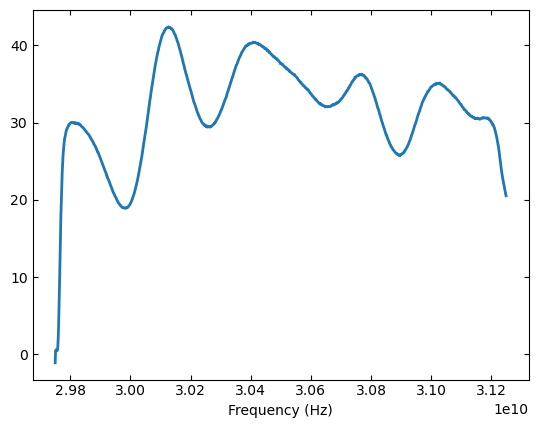

In [35]:
#scan=43
tsys = {43:92.62,46:91.72}
#bintable=0

tpon  = pnod.gettp(scan,sig=True,cal=False,bintable=bintable,fdnum=fdnum,plnum=plnum,ifnum=ifnum,subref=-1)
tpoff = pnod.gettp(scan,sig=True,cal=False,bintable=bintable,fdnum=fdnum,plnum=plnum,ifnum=ifnum,subref=1)
on  =  tpon.timeaverage(weights=weights)
off = tpoff.timeaverage(weights=weights)
print(f"ON TCAL: {on.meta['TCAL']} OFF TCAL: {off.meta['TCAL']}")
print(f"ON TSYS: {on.meta['TSYS']} OFF TSYS: {off.meta['TSYS']}")
idl=tsys[scan]*(on-off)/off
idl.plot()

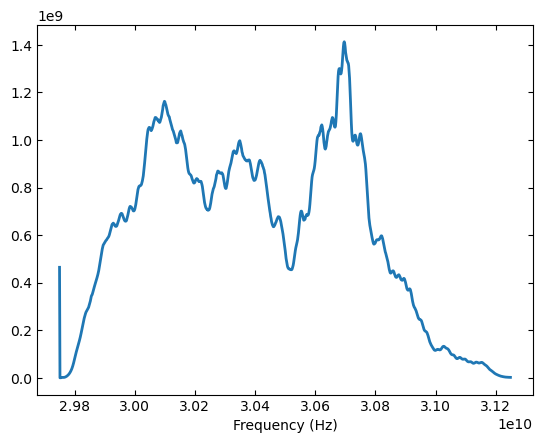

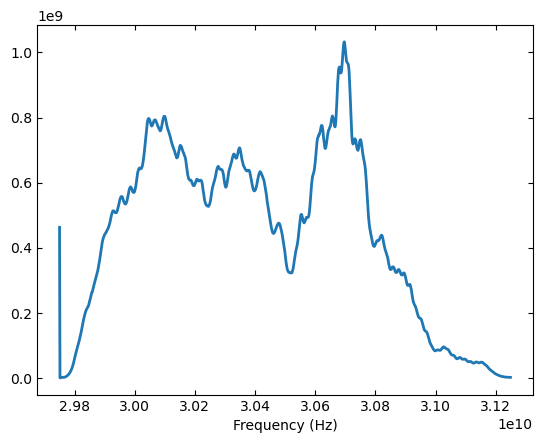

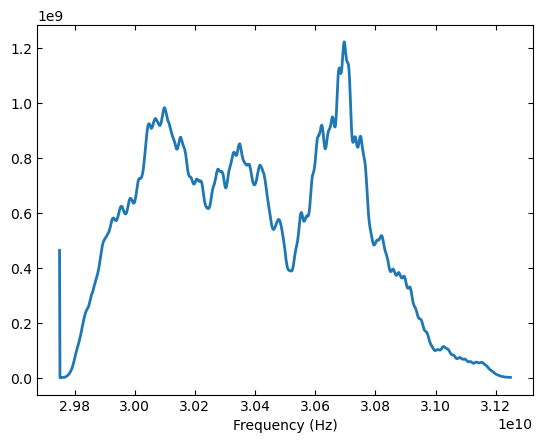

In [36]:
tpon.total_power(0).plot()
tpoff.total_power(0).plot()
(0.5*(tpon.total_power(0)+tpoff.total_power(0))).plot()

In [37]:
print(scan,ifnum,plnum,fdnum,weights)
os = pnod.gettp(scan=scan,sig=True,cal=True,ifnum=ifnum,plnum=plnum,fdnum=fdnum,weights=weights)
np.mean(os.tsys),os.tsys
os.timeaverage().meta['TSYS']

43 0 0 1 tsys
S  480
C  240
I  240
P  120
F  120
TPROWS len= 120
CALROWS on len= 120
TPSCAN nrows = 120
CALIBRATING
# scanrows 120, # calrows ON 120  # calrows OFF 120


97.5934680213617

In [38]:
s=pnod.getnod_ka(scan=scan,ifnum=ifnum,plnum=plnum,fdnum=fdnum,weights=weights)

S  480
I  480
P  240
F  240
SR  96
TPROWS len= 96
CALROWS on len= 48
TPSCAN nrows = 96
CALIBRATING
# scanrows 96, # calrows ON 48  # calrows OFF 48
S  480
I  480
P  240
F  240
SR  92
TPROWS len= 92
CALROWS on len= 46
TPSCAN nrows = 92
CALIBRATING
# scanrows 92, # calrows ON 46  # calrows OFF 46
Tsys(ON) = 112.86327458613192, Tsys(OFF) = 83.72940515501094, meanTsys = 98.29633987057143


(<Quantity 33.64874423>, 6.690488044912796, <Quantity -1.1520729>, <Quantity 45.02215984>)


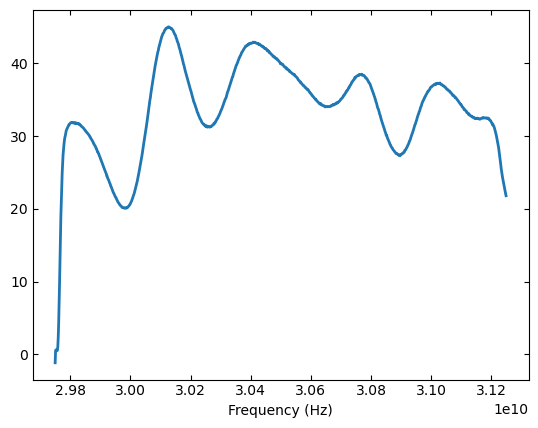

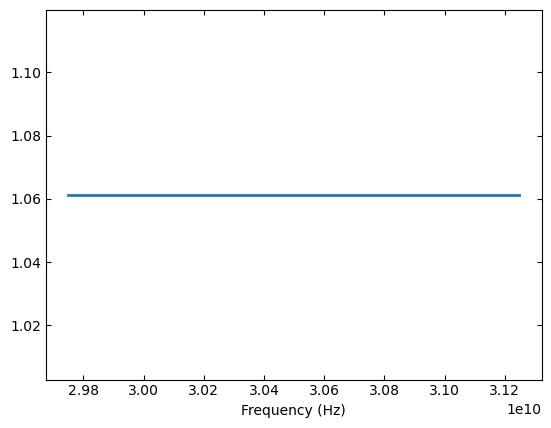

[1.06128633 1.06128633 1.06128633 ... 1.06128633 1.06128633 1.06128633]
(<Quantity 1.06128633>, 2.433564171948369e-16, <Quantity 1.06128633>, <Quantity 1.06128633>)
1.0612863298485362 5.676339870571425


In [39]:
print(s.stats())
s.plot()
diff=s/idl
diff.plot()
print(diff.data)
print(diff.stats())
print(s.meta['TSYS']/tsys[scan],s.meta['TSYS']-tsys[scan])

In [ ]:
type(s)

-----
# Debugging from here down.